# NFL Combine Regression Analysis

The goal of this project is to create a regression model that could be used to predict 40 yard dash times for college and at-home athletes. The requirements and features should be kept minimal to reduce the possibility of mis-measurement or needing special equipment. 

Approach:
1. Explore the data.
2. Attempt to use a few regression models on the full dataset.
3. Optimize the models.
4. Reduce features and compare the results to the full dataset.

In [928]:
# Import important standard libraries.
# ML models will be imported as we go.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [929]:
# Read the scraped and processed data.
combine_raw_df  = pd.read_csv('resources/combine_df.csv')

combine_raw_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
0,1987,Mike Adams,Arizona State,CB,69.8,198.0,28.6,4.42,13.0,32.0,118.0,4.60,NaN
1,1987,John Adickes,Baylor,C,74.8,266.0,33.4,4.97,25.0,26.5,103.0,4.60,NaN
2,1987,Tommy Agee,Auburn,FB,71.8,217.0,29.6,NaN,15.0,NaN,NaN,NaN,NaN
3,1987,David Alexander,Tulsa (OK),C,75.0,279.0,34.9,5.13,22.0,27.5,105.0,4.33,NaN
4,1987,Lyneal Alston,Southern Mississippi,WR,72.1,202.0,27.3,4.64,7.0,32.0,114.0,4.52,NaN


In [930]:
combine_raw_df.describe()

,Year,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
count,14164.000000,14164.000000,14164.000000,14164.000000,12634.000000,10276.000000,12178.000000,12055.000000,11099.000000,3810.000000
mean,2006.895792,73.754197,240.220983,30.859284,4.810259,19.813546,32.306150,113.403069,4.419774,7.263882
std,10.926223,2.651846,45.267732,4.429791,0.309922,6.474511,4.231685,9.759691,0.264741,0.383467
min,1987.000000,61.500000,142.000000,21.300000,4.210000,1.000000,17.500000,7.000000,3.730000,6.270000
25%,1997.000000,71.880000,203.000000,27.300000,4.570000,15.000000,29.500000,107.000000,4.230000,6.990000
50%,2008.000000,74.000000,231.500000,30.100000,4.730000,20.000000,32.500000,114.000000,4.380000,7.190000
75%,2017.000000,75.750000,276.000000,33.900000,5.020000,24.000000,35.375000,120.000000,4.580000,7.487500
max,2024.000000,82.400000,387.000000,47.700000,6.120000,51.000000,46.500000,147.000000,7.200000,8.820000


In [931]:
combine_raw_df.loc[combine_raw_df['40 Yard']==combine_raw_df['40 Yard'].min()]

,Year,Name,College,POS,Height (in),Weight (lbs),BMI,40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone
14161,2024,Xavier Worthy,Texas,WR,71.25,165.0,22.8,4.21,NaN,41.0,131.0,NaN,NaN


<AxesSubplot:ylabel='Frequency'>

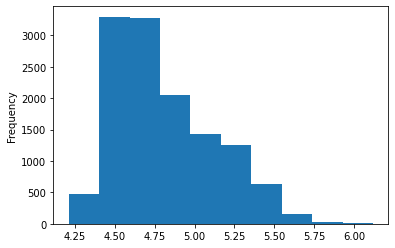

In [932]:
# Get a histogram of the 40 Yard data

combine_raw_df['40 Yard'].plot.hist()

For college athletes, it appears most of the 40 yard scores are in the 4.5 - 4.75 range. It should be noted that this data is trained using college athlete data, and not at-home athletes. If we had a control group, this chart could look very different.

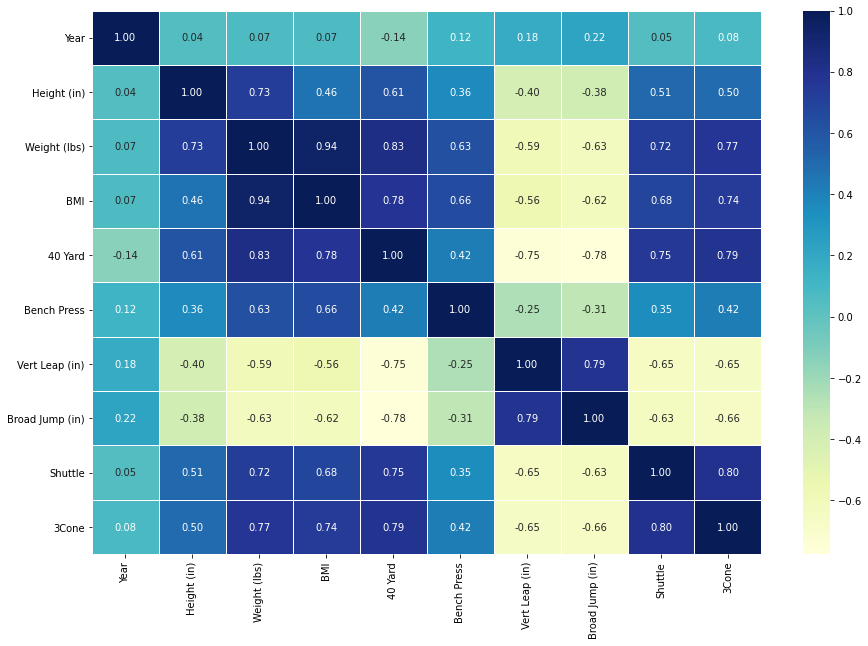

In [933]:
# Create correlation matrix to compare the features.

corr_matrix = combine_raw_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt='.2f',
                 cmap = 'YlGnBu')

<AxesSubplot:xlabel='Feature', ylabel='Correlation'>

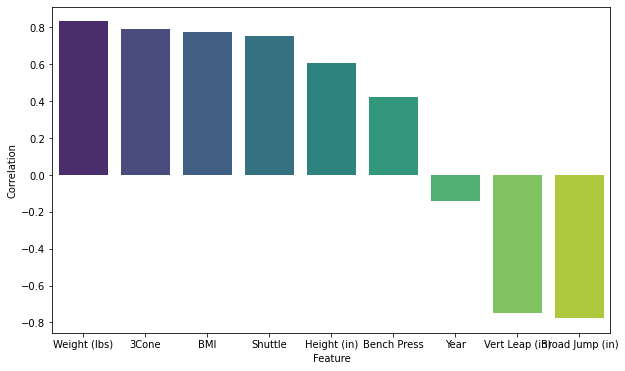

In [934]:
#Look specifically at 40 yard dash times.
corr_df = combine_raw_df.corr()

# Extract the correlation values for the '40 Yard' column
corr_40_yard = corr_df['40 Yard'].drop('40 Yard')  # Exclude the '40 Yard' itself to avoid a perfect correlation value of 1

# Convert to a DataFrame for easier plotting
corr_40_yard_df = corr_40_yard.reset_index()
corr_40_yard_df.columns = ['Feature', 'Correlation']

# Sort by correlation values for better visualization
corr_40_yard_df = corr_40_yard_df.sort_values(by='Correlation', ascending=False)

# Create a vertical bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_40_yard_df, x='Feature', y='Correlation', palette='viridis')

In this chart we can see that things like weight have a positive correlation with 40 yard dash times, meaning that the heavier an athlete is the higher their 40 yard dash time is likely to be. Broad Jump is negatively correlated with the 40 yard dash, so the further an athlete's broad jump the faster their 40 yard dash time. 

Although the 'year' feature has a correlation under -0.2, which may seem insignificant, we know that the average 40 yard dash times has decreased since it was first measured. As research and training programs improve we are likely to see this trend continue in the future. It's important to note context when looking at correlation and consider features even when the correlation appears low. 

### Prep the data for Machine Learning

We'll convert some of the text data to categories so that we can still use it. 

In [935]:
combine_df_ml = combine_raw_df.copy()

# This will turn all of the string values to category values
for label, content in combine_df_ml.items():
    if pd.api.types.is_string_dtype(content):
        combine_df_ml[label] = content.astype("category").cat.as_ordered()

combine_df_ml.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14164 entries, 0 to 14163
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             14164 non-null  int64   
 1   Name             14164 non-null  category
 2   College          14157 non-null  category
 3   POS              14164 non-null  category
 4   Height (in)      14164 non-null  float64 
 5   Weight (lbs)     14164 non-null  float64 
 6   BMI              14164 non-null  float64 
 7   40 Yard          12634 non-null  float64 
 8   Bench Press      10276 non-null  float64 
 9   Vert Leap (in)   12178 non-null  float64 
 10  Broad Jump (in)  12055 non-null  float64 
 11  Shuttle          11099 non-null  float64 
 12  3Cone            3810 non-null   float64 
dtypes: category(3), float64(9), int64(1)
memory usage: 1.8 MB


In order to keep as many rows as possible, we'll remove some of the features with that have a lot of null values. The 3Cone drill is missing a lot of values, and I'm assuming that bench press will have less of an impact on the other values. From previous exploration it seems many faster and lighter athletes opt out of the bench press. I'll also drop the name column based on the high number of unique values.

In [936]:
combine_df_ml.isnull().sum()

Year                   0
Name                   0
College                7
POS                    0
Height (in)            0
Weight (lbs)           0
BMI                    0
40 Yard             1530
Bench Press         3888
Vert Leap (in)      1986
Broad Jump (in)     2109
Shuttle             3065
3Cone              10354
dtype: int64

In [937]:
# Drop null values
combine_df_ml.drop(columns=['Bench Press', '3Cone'], inplace=True)
combine_df_ml.dropna(inplace=True)

In [938]:
combine_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10734 entries, 0 to 14160
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             10734 non-null  int64   
 1   Name             10734 non-null  category
 2   College          10734 non-null  category
 3   POS              10734 non-null  category
 4   Height (in)      10734 non-null  float64 
 5   Weight (lbs)     10734 non-null  float64 
 6   BMI              10734 non-null  float64 
 7   40 Yard          10734 non-null  float64 
 8   Vert Leap (in)   10734 non-null  float64 
 9   Broad Jump (in)  10734 non-null  float64 
 10  Shuttle          10734 non-null  float64 
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


In [939]:
# Turn categories into numeric values so they work with the models.

for label, content in combine_df_ml.items():
    if not pd.api.types.is_numeric_dtype(content):
        #Turn categories into numbers and add +1
        combine_df_ml[label] = pd.Categorical(content).codes + 1

In [940]:
# Get the columns

combine_df_ml.columns

Index(['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI',
       '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle'],
      dtype='object')

In [941]:
# Split data into training and validation

df_val = combine_df_ml[combine_df_ml.Year > 2015]
df_train = combine_df_ml[combine_df_ml.Year <= 2015]

len(df_val)/len(combine_df_ml), len(df_train)/len(combine_df_ml)

(0.2692379355319545, 0.7307620644680455)

I originally selected 2017 as the year to split the data, which was close to 80% training and 20% validation. However, my MAE value was slightly better on the validation dataset when the year was 2015.

In [942]:
# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((7844, 10), (7844,), (2890, 10), (2890,))

### Create Evaluation Metrics

We'll look at Mean Squared Error and R^2 to evaluate the model. We'll compare the training against the valid data to assess over and under fitting.

In [943]:
# Create evaluation function
from sklearn.metrics import mean_absolute_error, r2_score

# Create function to evaluate model o na few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
            "Valid MAE": mean_absolute_error(y_valid, val_preds),
            "Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

### Train and Test the Data Using Different Models

We'll start with Random Forest and see how that performs, then we'll look at other methods like Linear Regression and Lasso.

In [944]:
# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

In [945]:
%%time
# Cutting down the max number of samples for each estimator can improve training time.
model.fit(X_train, y_train)

Wall time: 868 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

In [946]:
show_scores(model)

{'Training MAE': 0.034106004589495115,
 'Valid MAE': 0.08984882352941176,
 'Training R^2': 0.9801658987363381,
 'Valid R^2': 0.85485369622086}

Our MAE looks a lot higher for the valid dataset versus the dataset for training. We are probably dealing with some overfitting here. There might be a few reasons for this, we may not have enough sample data or maybe the model is too complex. Acquiring more data is out of our hands, but we could possibly adjust the datasets to get more values in the training dataset. we could also try different model to see if that helps. Identifying and removing outliers could help with predictions as well and will be the first place we start.

In [947]:
# Check Z Scores in our data
from scipy.stats import zscore

for column in list(combine_df_ml.columns):
    print(f"{column}: ", abs(zscore(combine_df_ml[column]).max().round(2)))

Year:  1.61
Name:  1.75
College:  1.71
POS:  1.28
Height (in):  3.24
Weight (lbs):  3.21
BMI:  3.78
40 Yard:  4.19
Vert Leap (in):  3.38
Broad Jump (in):  3.49
Shuttle:  10.52


In [948]:

combine_df_ml_no_outliers = combine_df_ml.copy()

# Calculate z-scores for all columns at once and take the absolute values
z_scores_df = np.abs(combine_df_ml_no_outliers.apply(zscore))

# Set threshold
threshold = 3

# Filter rows where z-scores in all columns are below the threshold
combine_df_ml_no_outliers = combine_df_ml_no_outliers[(z_scores_df < threshold).all(axis=1)]

# Verify if the outliers are removed by checking max z-scores in each column
for column in list(combine_df_ml_no_outliers.columns):
    print(f"{column}: ", abs(zscore(combine_df_ml_no_outliers[column]).max().round(2)))


Year:  1.61
Name:  1.75
College:  1.71
POS:  1.27
Height (in):  2.96
Weight (lbs):  2.92
BMI:  3.03
40 Yard:  3.07
Vert Leap (in):  2.82
Broad Jump (in):  3.02
Shuttle:  3.12


In [949]:
# Try random forest again

# Split data into training and validation

df_val = combine_df_ml_no_outliers[combine_df_ml_no_outliers.Year > 2015]
df_train = combine_df_ml_no_outliers[combine_df_ml_no_outliers.Year <= 2015]

# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

# Cutting down the max number of samples for each estimator can improve training time.
model.fit(X_train, y_train)

show_scores(model)



{'Training MAE': 0.03380252025202513,
 'Valid MAE': 0.08903448516579407,
 'Training R^2': 0.9797875002289521,
 'Valid R^2': 0.85569893247621}

There was a modest increase in our Valid MAE, which could be usefull in the future.

In [950]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(n_jobs=-1)

lin_model.fit(X_train,y_train)

show_scores(lin_model)

{'Training MAE': 0.09600407035886775,
 'Valid MAE': 0.09708093076579653,
 'Training R^2': 0.8400589658893471,
 'Valid R^2': 0.8285821927227752}

The training MAE and valid MAE are much closer using linear regression, however our valid MAE is still higher than we saw with the random forest model.

We'll use Lasso, Ridge, and ElasticNet (a combination of both) next. Theses algorithms are known for balancing the impact of highly correlated features, so this may help us reduce error.

In [951]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

ridge = Ridge(alpha=1,random_state=42)
lasso = Lasso(alpha=0.1, random_state=42)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=42)

ridge.fit(X_train,y_train)
lasso.fit(X_train,y_train)
elastic_net.fit(X_train,y_train)

print("ridge: ",show_scores(ridge))
print("lasso: ",show_scores(lasso))
print("elastic_net: ", show_scores(elastic_net))

ridge:  {'Training MAE': 0.09600409347609307, 'Valid MAE': 0.09709480423926038, 'Training R^2': 0.8400588085949672, 'Valid R^2': 0.828525725343366}
lasso:  {'Training MAE': 0.10184981999951347, 'Valid MAE': 0.10170205888482015, 'Training R^2': 0.8200706648469206, 'Valid R^2': 0.8088536559773314}
elastic_net:  {'Training MAE': 0.0991849416690413, 'Valid MAE': 0.10268943490299572, 'Training R^2': 0.8296825412182257, 'Valid R^2': 0.8072879223647597}


In [952]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Off the bat, it does not look like it's giving us any improvement over our linear regression or random forest models. So we may try a different approach by optimizing our random forest model.

We'll use RandomSearchCV to test different parameters and see if some of them help us improve our MAE and reduce over fitting.

In [953]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Dfferent RandomForestRegressor hyper parameters
rs_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rs_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

# For the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 2min 13s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [954]:
# Find the best hyperparams
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': None}

In [955]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 0.06613251243278748,
 'Valid MAE': 0.08759648887517481,
 'Training R^2': 0.9218619381125854,
 'Valid R^2': 0.8610074751710294}

The results show both a decrease in Valid MAE and the difference between Training and Valid MAE. A nice improvement.

We'll see if a boosted model like XGBoost can provide even better results than what we've seen.

In [956]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_jobs=-1, random_state = 42)

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [957]:
show_scores(xgb_model)

{'Training MAE': 0.04974129342168312,
 'Valid MAE': 0.09368794255814208,
 'Training R^2': 0.9546064272755727,
 'Valid R^2': 0.8386075655618488}

In [958]:
# Instantiate RandomizedSearchCV model for XGBoost
rs_xgb_model = RandomizedSearchCV(XGBRegressor(n_jobs=-1,
                                        random_state=42),
                              param_distributions=rs_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

In [959]:
rs_xgb_model.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[22:31:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:31:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:31:12] WA

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          num_parallel_tree=None,
                                        

In [960]:
# Evaluate the RandomizedSearch model
show_scores(rs_xgb_model)

{'Training MAE': 0.07989903252213998,
 'Valid MAE': 0.08979682142780297,
 'Training R^2': 0.8896060783636671,
 'Valid R^2': 0.8549234429741743}

Despite boosting and the same optimization criteria, XGBoost is not performing better than random forest. For this case, we'll use the optimized random forest model and reduced our features using similar criteria.

### Reducing Features
 Broad jump and vertical leap were both highly correlated with the 40 yard dash, but vertical leap is slightly more difficult to measure at home. This being the case, we'll attempt to create a model using only broad jump as a performance metric.

We'll compare against the previous model to see how much of an error difference we get by dropping columns.

In [961]:
combine_df_ml_no_outliers.columns

Index(['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI',
       '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle'],
      dtype='object')

In [962]:
# Create datasets with reduced columns
combine_df_reduced_ml = combine_df_ml_no_outliers.drop(columns=['Name', 'College', 'POS', 'Vert Leap (in)','BMI','Vert Leap (in)','Shuttle'])

# Create a list of all of the models to test
dfs_to_test = [combine_df_ml, combine_df_ml_no_outliers, combine_df_reduced_ml]
df_names = ["combine_df_ml", "combine_df_ml_no_outliers", "combine_df_reduced_ml"]

df_dict = dict(zip(df_names, dfs_to_test))

# Get a list of the columns for each of the dataframes we'll test
for key, value in df_dict.items():
    print(key,f':\n',list(value.columns))


combine_df_ml :
 ['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI', '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle']
combine_df_ml_no_outliers :
 ['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)', 'BMI', '40 Yard', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle']
combine_df_reduced_ml :
 ['Year', 'Height (in)', 'Weight (lbs)', '40 Yard', 'Broad Jump (in)']



The default variables for random forest worked well for the last models. We'll use that to compare the dataframes we have here.

In [963]:
#Cycle through our dfs and create a dataframe of the model scores

df_scores = pd.DataFrame()

combine_score_predictive_model = RandomForestRegressor(**rs_model.best_params_,random_state=42)

for name, df in df_dict.items():

    df_temp = df.copy()

    # Split data into training and validation
    df_val = df_temp[df_temp.Year > 2015]
    df_train = df_temp[df_temp.Year <= 2015]

    # Split data into X and y
    X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
    X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

    combine_score_predictive_model.fit(X_train, y_train)

    # Create a dictionary from the scores
    scores_dict = show_scores(combine_score_predictive_model)

    # Append name to dicitionary
    scores_dict['Version'] = name

    df_scores = df_scores.append(scores_dict, ignore_index=True)

# Rearrange the columns
cols = ['Version'] + [col for col in df_scores.columns if col != 'Version']
df_scores = df_scores[cols]

# Display the final scores dataframe with 'Model' as the first column
df_scores

,Version,Training MAE,Training R^2,Valid MAE,Valid R^2
0,combine_df_ml,0.066687,0.922777,0.087923,0.861847
1,combine_df_ml_no_outliers,0.066133,0.921862,0.087596,0.861007
2,combine_df_reduced_ml,0.074985,0.900010,0.094237,0.835887


Based on the current values as of writing, the valid MAE of the original Combine DF is -10.6% lower than the Reduced Combine DF without Vertical Leap. As an amatuer Machine Learning Engineer, it's difficult to assess the impact of this based on the error calculation alone. What would help me, and people like me, is to see a the predictions compared to the actual values. 

As a novice, what I would like to see is the predicted values of each version compared against each other and the actual values.

In [964]:
# Cycle through our dfs and create a df for the predicted values 

df_preds = pd.DataFrame()

for name, df in df_dict.items():

    df_temp = df.copy()

    # Split data into training and validation
    df_val = df_temp[df_temp.Year > 2015]
    df_train = df_temp[df_temp.Year <= 2015]

    # Split data into X and y
    X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
    X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

    combine_score_predictive_model.fit(X_train, y_train)

    # Create a dictionary from the scores
    y_pred = combine_score_predictive_model.predict(X_valid)

    # Append name to dicitionary
    name_predictions ="y_preds: " + name

    df_preds[name_predictions] = pd.Series(y_pred)


# Add the actual values, should be the same after the loop
df_valid = combine_df_ml[combine_df_ml.Year > 2015]
y_valid = df_valid['40 Yard'].reset_index(drop=True)

df_preds['y_valid'] = y_valid

# Show the results:
df_preds.head(20)

,y_preds: combine_df_ml,y_preds: combine_df_ml_no_outliers,y_preds: combine_df_reduced_ml,y_valid
0,5.005838,5.003772,4.964669,5.10
1,4.766753,4.795121,4.725495,4.64
2,4.641376,4.632083,4.566359,4.83
3,4.533520,4.534806,4.576930,4.66
4,4.854019,4.876964,4.828625,4.76
5,4.509874,4.511879,4.511252,4.49
6,5.380297,5.333333,5.372753,5.57
7,4.803518,4.793686,4.717158,4.84
8,5.220438,5.231930,5.126209,5.29
9,4.551880,4.540994,4.540548,4.67


In [965]:
# Split up the data for just the dataset

# Split data into training and validation
df_val = combine_df_reduced_ml[df_temp.Year > 2015]
df_train = combine_df_reduced_ml[df_temp.Year <= 2015]

# Split data into X and y
X_train, y_train = df_train.drop("40 Yard", axis=1), df_train['40 Yard']
X_valid, y_valid = df_val.drop("40 Yard", axis=1), df_val['40 Yard']

combine_score_predictive_model.fit(X_train, y_train)

show_scores(combine_score_predictive_model)

{'Training MAE': 0.07498477083972198,
 'Valid MAE': 0.09423716850769191,
 'Training R^2': 0.9000099695527771,
 'Valid R^2': 0.83588729139583}

In [966]:
# Create a new Random Forest model with the new parameters
combine_score_predictive_model = RandomForestRegressor(**rs_reduced_model.best_params_,random_state=42)

combine_score_predictive_model.fit(X_train, y_train)

show_scores(combine_score_predictive_model)

{'Training MAE': 0.0854857601867973,
 'Valid MAE': 0.09417871284109618,
 'Training R^2': 0.8710218138417656,
 'Valid R^2': 0.8357316650342479}

In [967]:
# Save the model for future use.
import pickle

pickle.dump(combine_score_predictive_model, open('combine_score_predictive_model.pkl', 'wb'))



In [969]:
# Get predictions from each tree
predictions_per_tree = np.array([tree.predict(X_valid) for tree in combine_score_predictive_model.estimators_])

# Calculate prediction mean
mean_prediction = np.mean(predictions_per_tree, axis=0)

# Calculate prediction intervals (e.g., 90% confidence)
lower_bound = np.percentile(predictions_per_tree, 5, axis=0)
upper_bound = np.percentile(predictions_per_tree, 95, axis=0)

# Display bounds

data = {'y valid': y_valid, 
        'prediction': mean_prediction, 
        'lower bound': lower_bound, 
        'upper bound': upper_bound}

bounded_predictions_df = pd.DataFrame(data)

bounded_predictions_df.sample(10)

,y valid,prediction,lower bound,upper bound
11940,4.50,4.618146,4.567719,4.675953
13758,4.73,4.741767,4.661187,4.813773
13586,4.65,4.542842,4.503169,4.590289
13849,4.44,4.533374,4.466984,4.618769
11083,4.77,4.778781,4.704816,4.860780
13816,4.64,4.577857,4.470431,4.667239
12984,4.64,4.515588,4.475221,4.568579
12948,5.33,5.212229,5.113176,5.328128
10297,5.00,5.095783,4.983825,5.201888
11085,5.50,5.219397,5.135500,5.339015
